<font size="10">Bistable Traveling Waves with PINNs</font>

<font size="4">This notebook employs a physics informed neural network (PINN) to demonstrate the existence of traveling wave solutions to the bistable reaction-diffusion equation: 
$\partial_t u = \partial_x^2 u + u(1 - u)(u - a), \quad a \in (0,1), \quad u = u(x,t).$
</font>

<font size="4">Through a series of manipulations, traveling wave solutions to the above partial differential equation are equivalent to solving the (parameterized) boundary value problem:
$U U' + cU + \xi(1 - \xi)(\xi - a), \quad U(0) = U(1) = 0, \quad \xi \in [0,1],$
</font>

<font size="4">where 
$U = U(\xi)$, $\xi = x - ct$ is the new independent variable and $c \in \mathbb{R}$ is the (unknown) speed of propagation.</font> 


<font size="4">The neural network is trained so that it approximates the function 
$\xi \mapsto U(\xi)$ for each $\xi \in [0,1]$. The wave speed parameter $c$ is considered as a trainable network parameter that is found through the training process.</font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 5.4 of the book <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network.</font>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f 
import torch.optim as optim
from time import time
import numpy as np

In [2]:
dtype = torch.float32

# set constants
pi = torch.tensor(np.pi, dtype=dtype)

In [3]:
# Define residual of the ODE
def fun_r(c, x, u, u_x):
    a = 0.9
    return u*u_x + c*u + x*(1 - x)*(x - a)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set number of data points
N_r = 1000

# Set boundary
xmin = 0.
xmax = 1.
X_b = torch.tensor([[xmin], [xmax]], dtype=dtype, requires_grad=True).to(device)

# Set random seed for reproducible results
torch.manual_seed(0)

# Interior points
X_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True) * (xmax-xmin) + xmin
X_r = X_r.to(device)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=12, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        # Create variable for the wave speed
        self.c = nn.Parameter(torch.tensor(0.0, requires_grad=True, dtype=dtype))

        # Input is one-dimensional
        self.input_layer = nn.Linear(1, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer)
            
            for _ in range(num_hidden_layers)
        ])

        # Output is one-dimensional 
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        x = f.selu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)
            x = f.selu(x)
        x = self.output_layer(x)
        return x

In [20]:
def compute_loss(model, X_r, X_b):
    X_r = X_r.detach().requires_grad_(True)
    # Determine residual
    u = model(X_r)

    # Compute gradient u_x
    u_x = torch.autograd.grad(u, X_r, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Get wave speed variable
    c = model.c

    # Define loss
    loss = torch.mean(fun_r(c, X_r, u, u_x)**2)

    # Neumann boundary conditions in loss
    u0 = model(X_b)
    loss += torch.mean(u0**2)
    
    return loss

In [18]:
# Initialize model aka P(U)
model = NeuralNetwork()
model = model.to(device)

# Learning rate schedule
lr_schedule = [1e-3, 1e-4, 1e-5]
def get_lr(epoch):
    if epoch < 1000:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]
    
# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr_schedule[0])

# Number of training epochs
N = 10000
hist = []

In [ ]:
# Start timer
t0 = time()

for i in range(N+1):
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    # Reset gradient of optimizer to 0
    optimizer.zero_grad()

    # Compute loss 
    loss = compute_loss(model, X_r, X_b)
    loss.backward()

    # Perform gradient descent step
    optimizer.step()

    # Append current loss to hist
    hist.append(loss.item())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss.item()))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.31998026e+00
It 00050: loss = 6.48366148e-03
It 00100: loss = 6.45306427e-03


KeyboardInterrupt: 

0.47577867
tensor([[-0.0002],
        [ 0.0005]], grad_fn=<AddmmBackward0>)


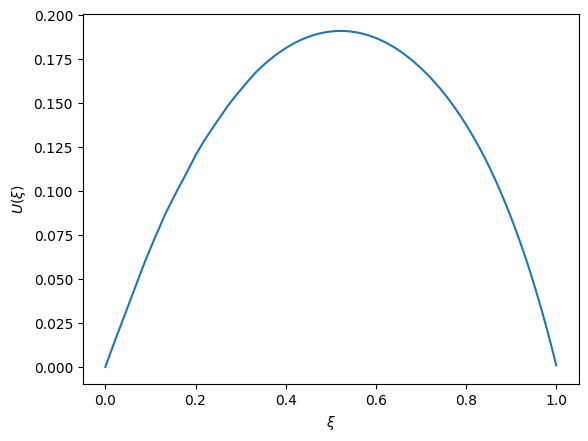

In [9]:
# View trained model specs
from matplotlib import pyplot as plt

# Predicted wave speed
print(model.c.detach().numpy())

# Determine predictions of u(x)
X = torch.tensor(np.linspace(xmin,xmax, 5000).reshape(-1,1), dtype=dtype)
upred = model(X)

# Plot results
plt.plot(X,upred.detach().numpy())
plt.xlabel(r'$\xi$')
plt.ylabel(r'$U(\xi)$')

# Check boundary conditions
u_b = model(model(X_b))
print(u_b)

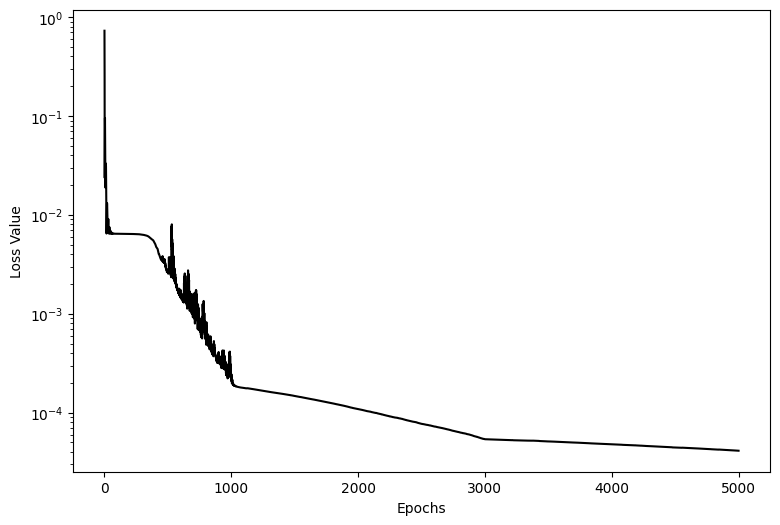

In [11]:
# View loss function values vs. number of epochs
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Value');